## Step 1. Dataset Selection

We'll use the RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) dataset. This dataset is perfect for our multi-modal approach as it contains both audio and video data.

## Step 2. Data Cleaning
Create a script to clean and organize the data:


In [2]:
import os
import pandas as pd
import librosa

def clean_ravdess_data(data_path):
    data = []
    for actor_folder in os.listdir(data_path):
        actor_path = os.path.join(data_path, actor_folder)
        for file_name in os.listdir(actor_path):
            file_path = os.path.join(actor_path, file_name)
            
            # Extract information from file name
            parts = file_name.split('-')
            if len(parts) != 7:
                print(f"Unexpected file name format: {file_name}")
                continue
            
            modality, vocal_channel, emotion, intensity, statement, repetition, actor = parts
            
            # Strip the .wav extension from the actor part
            actor = actor.split('.')[0]
            
            # Load audio to check if it's corrupted
            try:
                audio, _ = librosa.load(file_path, duration=1)  # Load just 1 second to check
            except Exception as e:
                print(f"Corrupted file: {file_path} | Error: {e}")
                continue
            
            data.append({
                'file_path': file_path,
                'modality': int(modality),
                'vocal_channel': int(vocal_channel),
                'emotion': int(emotion),
                'intensity': int(intensity),
                'statement': int(statement),
                'repetition': int(repetition),
                'actor': int(actor),
                'audio_length': librosa.get_duration(filename=file_path)
            })
    
    df = pd.DataFrame(data)
    
    # Remove outliers based on audio length
    q1 = df['audio_length'].quantile(0.25)
    q3 = df['audio_length'].quantile(0.75)
    iqr = q3 - q1
    df = df[(df['audio_length'] >= q1 - 1.5*iqr) & (df['audio_length'] <= q3 + 1.5*iqr)]
    
    return df

# Update the path to point to your dataset
data_path = 'D:/1188976/Audio_Speech_Actors_01-24'

# Clean the dataset and save to a CSV file
df = clean_ravdess_data(data_path)
df.to_csv('cleaned_ravdess_data.csv', index=False)


C:\Users\leoko\AppData\Local\Temp\ipykernel_16560\1604396594.py:39: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  'audio_length': librosa.get_duration(filename=file_path)


## Step 3. Data Exploration 
Create a script for data exploration:

C:\Users\leoko\AppData\Local\Temp\ipykernel_16560\2548360001.py:26: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(y), ref=np.max),


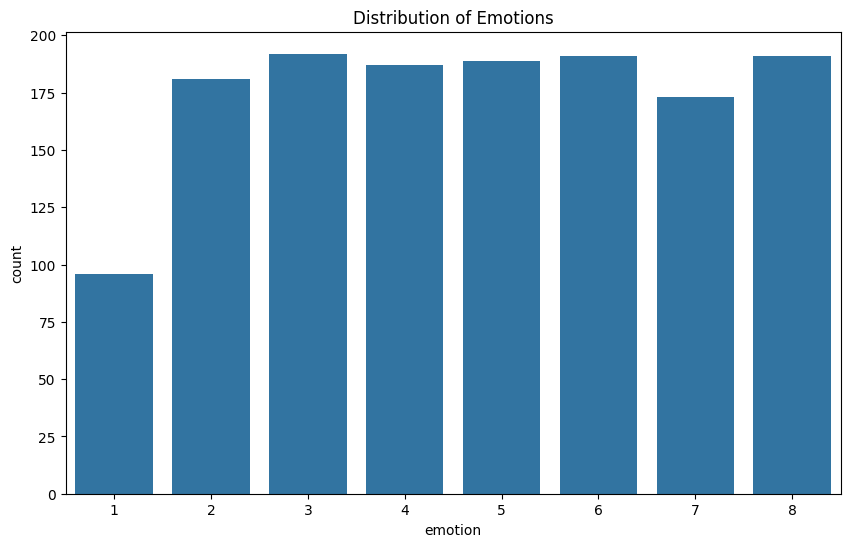

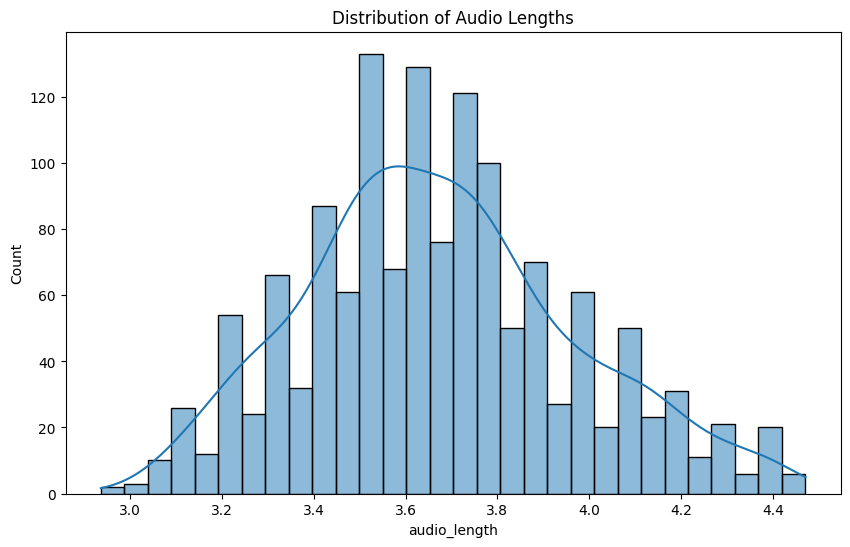

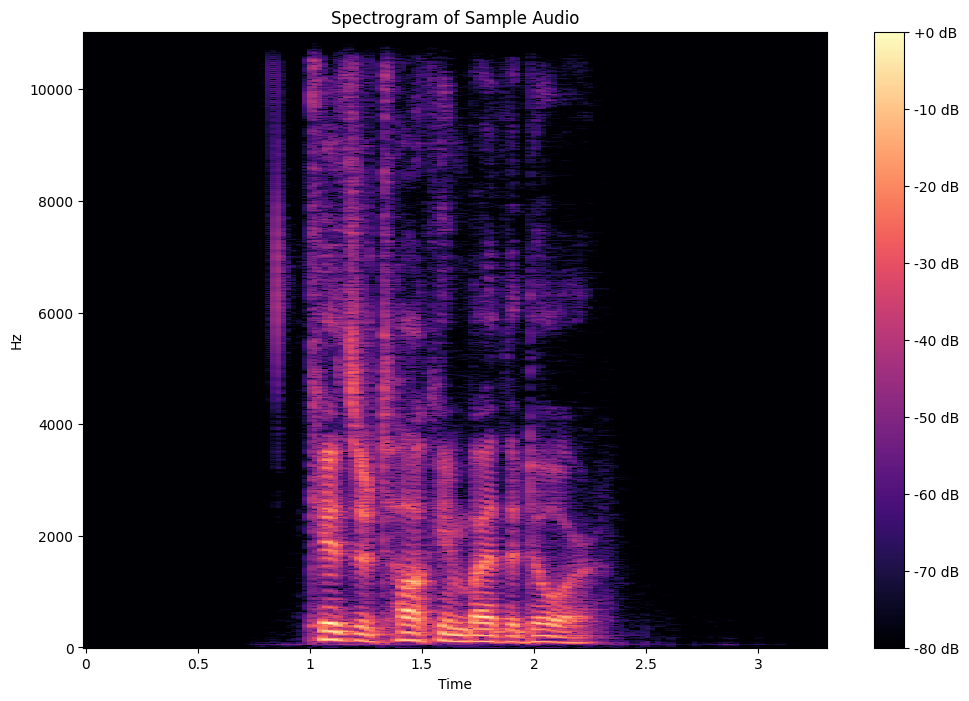

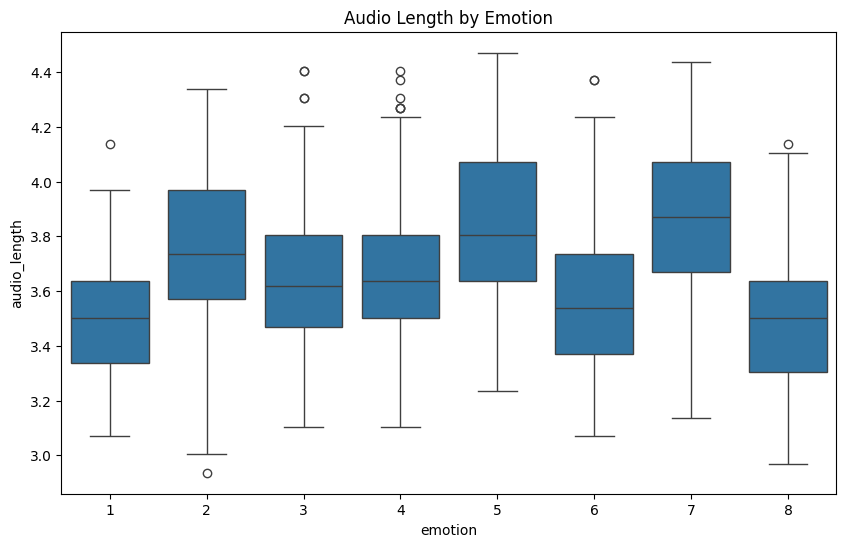

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import numpy as np

df = pd.read_csv('cleaned_ravdess_data.csv')

# Plot emotion distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=df)
plt.title('Distribution of Emotions')
plt.savefig('emotion_distribution.png')

# Plot audio length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['audio_length'], bins=30, kde=True)
plt.title('Distribution of Audio Lengths')
plt.savefig('audio_length_distribution.png')

# Plot spectrogram of a sample audio
sample_audio_path = df['file_path'].iloc[0]
y, sr = librosa.load(sample_audio_path)
plt.figure(figsize=(12, 8))
librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(y), ref=np.max),
                         y_axis='hz', x_axis='time')
plt.title('Spectrogram of Sample Audio')
plt.colorbar(format='%+2.0f dB')
plt.savefig('sample_spectrogram.png')

# Correlation between emotion and audio length
plt.figure(figsize=(10, 6))
sns.boxplot(x='emotion', y='audio_length', data=df)
plt.title('Audio Length by Emotion')
plt.savefig('audio_length_by_emotion.png')

## Step 4. Feature Engineering 
For our multi-modal approach, we'll use transfer learning, so traditional feature engineering is less crucial. However, we'll create a custom dataset class:

In [60]:
import os
import torch
import torchaudio
import torchvision
import cv2
import torch.nn.functional as F
from torch.utils.data import Dataset

class RAVDESSDataset(Dataset):
    def __init__(self, df, max_audio_length=160000, transform=None):
        self.df = df
        self.max_audio_length = max_audio_length  # Set a maximum audio length
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = row['file_path']
        
        # Determine the type (song or speech) and actor from the audio path
        if 'Audio_Song_Actors' in audio_path:
            video_base_folder = 'Video_Song_Actor_'
        elif 'Audio_Speech_Actors' in audio_path:
            video_base_folder = 'Video_Speech_Actor_'
        else:
            raise ValueError(f"Unexpected path: {audio_path}")

        actor_number = audio_path.split('\\')[-2].split('_')[-1]
        video_folder = f"{video_base_folder}{int(actor_number):02d}"
        video_path = os.path.join(os.path.dirname(os.path.dirname(audio_path)), video_folder, f"Actor_{actor_number}", os.path.basename(audio_path).replace('.wav', '.mp4'))
        
        # Load audio in mono
        audio, sr = torchaudio.load(audio_path, normalize=True)
        audio = torch.mean(audio, dim=0, keepdim=True)  # Convert to mono by averaging channels if stereo
        audio = torchaudio.transforms.Resample(sr, 16000)(audio)
        
        # Pad or truncate audio to the maximum length
        if audio.size(1) > self.max_audio_length:
            audio = audio[:, :self.max_audio_length]
        else:
            padding = self.max_audio_length - audio.size(1)
            audio = F.pad(audio, (0, padding))

        # Reshape audio to the format expected by Wav2Vec2Model
        audio = audio.squeeze(0)  # Remove the extra channel dimension, resulting in [sequence_length]

        # Check if video file exists
        if not os.path.exists(video_path):
            print(f"Warning: Video file not found for {audio_path}. Using audio only.")
            video = torch.zeros((3, 224, 224))  # Placeholder for missing video, single frame, adjust dimensions as needed
        else:
            # Load video using OpenCV
            cap = cv2.VideoCapture(video_path)
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            cap.release()

            if len(frames) == 0:
                raise ValueError(f"No frames found in video: {video_path}")
            
            # Select a single frame or average the frames to create a single image
            video = torch.tensor(np.array(frames[0]))  # Use the first frame
            
            # Ensure video has dimensions (C, H, W)
            if video.dim() == 3:
                video = video.permute(2, 0, 1)  # Convert (H, W, C) to (C, H, W)

            # Resize to the expected input size if necessary
            video = torchvision.transforms.Resize((224, 224))(video)

        if self.transform:
            audio = self.transform(audio)
            video = self.transform(video)
        
        label = torch.tensor(int(row['emotion']) - 1)  # Adjust label to start from 0
        
        return audio, video, label


## Step 5. Model Selection 
We'll implement our multi-modal model and compare it with traditional models:

In [61]:
import torch
import torch.nn as nn
from transformers import Wav2Vec2Model, ViTModel

class MultiModalEmotionRecognizer(nn.Module):
    def __init__(self, num_emotions):
        super().__init__()
        self.audio_encoder = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
        self.visual_encoder = ViTModel.from_pretrained("google/vit-base-patch16-224")
        self.fusion = nn.Linear(self.audio_encoder.config.hidden_size + 
                                self.visual_encoder.config.hidden_size, 512)
        self.classifier = nn.Linear(512, num_emotions)

    def forward(self, audio_input, visual_input):
        audio_features = self.audio_encoder(audio_input).last_hidden_state.mean(dim=1)
        visual_features = self.visual_encoder(visual_input).last_hidden_state[:, 0, :]
        combined_features = torch.cat((audio_features, visual_features), dim=1)
        fused_features = self.fusion(combined_features)
        output = self.classifier(fused_features)
        return output

# Traditional models for comparison
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

## Step 6. Hyperparameter Tuning 
First, we prepare our dataset 

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

# Load the cleaned data
df = pd.read_csv('cleaned_ravdess_data.csv')

# Create the full dataset
full_dataset = RAVDESSDataset(df)

# Split the data into train, validation, and test sets
train_idx, test_idx = train_test_split(np.arange(len(full_dataset)), test_size=0.2, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Create samplers for the DataLoaders
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Define a function to create DataLoaders
def create_data_loaders(batch_size):
    train_loader = DataLoader(full_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(full_dataset, batch_size=batch_size, sampler=val_sampler)
    test_loader = DataLoader(full_dataset, batch_size=batch_size, sampler=test_sampler)
    return train_loader, val_loader, test_loader

: 

We'll use Optuna for hyperparameter tuning:

In [63]:
import optuna
import torch
import torch.nn as nn
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for audio, video, labels in loader:
        audio, video, labels = audio.to(device), video.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(audio, video)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for audio, video, labels in loader:
            audio, video, labels = audio.to(device), video.to(device), labels.to(device)
            outputs = model(audio, video)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = correct / total
    return total_loss / len(loader), accuracy

def objective(trial):
    # Define hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    num_epochs = trial.suggest_int('num_epochs', 5, 20)
    
    # Create model with trial hyperparameters
    model = MultiModalEmotionRecognizer(num_emotions=8).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Create data loaders
    train_loader, val_loader, _ = create_data_loaders(batch_size)
    
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion)
        
        # Report intermediate objective value
        trial.report(val_accuracy, epoch)
        
        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return val_accuracy

# Create the study object and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print('Best parameters:', best_params)
print('Best validation accuracy:', study.best_value)

# Train the final model with the best parameters
final_model = MultiModalEmotionRecognizer(num_emotions=8).to(device)
final_optimizer = Adam(final_model.parameters(), lr=best_params['lr'])
final_criterion = nn.CrossEntropyLoss()

train_loader, val_loader, test_loader = create_data_loaders(best_params['batch_size'])

for epoch in range(best_params['num_epochs']):
    train_loss = train_one_epoch(final_model, train_loader, final_optimizer, final_criterion)
    val_loss, val_accuracy = evaluate(final_model, val_loader, final_criterion)
    print(f'Epoch {epoch+1}/{best_params["num_epochs"]}, '
          f'Train Loss: {train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.4f}')

# Evaluate on the test set
test_loss, test_accuracy = evaluate(final_model, test_loader, final_criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

[I 2024-08-11 00:59:35,659] A new study created in memory with name: no-name-c66f6eff-f4d6-4706-aa87-f02f37d33a72
C:\Users\leoko\AppData\Local\Temp\ipykernel_16560\670810806.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
c:\Git\RAVDESS\venv\Lib\site-packages\transformers\configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizatio

c:\Git\RAVDESS\venv\Lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


## Step 7. Pickle Files

In [ ]:
import pickle

def save_model(model, filename):
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

save_model(multi_modal_model, 'multi_modal_model.pkl')
save_model(random_forest_model, 'random_forest_model.pkl')
save_model(svm_model, 'svm_model.pkl')
save_model(mlp_model, 'mlp_model.pkl')

## Step 8. Flask or Streamlit Web App

## Step 9. GitHub Structure 

emotion-recognition/
├── data/
│   └── cleaned_ravdess_data.csv
├── models/
│   ├── multi_modal_model.pkl
│   ├── random_forest_model.pkl
│   ├── svm_model.pkl
│   └── mlp_model.pkl
├── src/
│   ├── data_cleaning.py
│   ├── data_exploration.py
│   ├── model.py
│   └── train.py
├── app.py
├── requirements.txt
└── README.md